# Sentiment Analysis Stock-Twits

In [1]:
import numpy as np
import pandas as pd
import pylab as plt
import seaborn as sns

from helper import *

from scipy import sparse as sp_sparse

from sklearn.model_selection import train_test_split

data_dir = './'

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/gshyam/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
df = pd.read_csv(data_dir+'stock_twits_processed.csv')
df.head(2)

,message_body,sentiment,timestamp,message_processed
0,$FITB great buy at 26.00...ill wait,4,2018-07-01T00:00:09Z,great buy ill wait
1,#STAAnalystAlert for $TDG : Jefferies Maintain...,4,2018-07-01T00:01:24Z,staanalystalert jefferies maintains rating hol...


## Bag of Words Method

In [3]:
from collections import Counter
ALL_WORDS = [word for text in df['message_processed'] for word in text.split() ]
words_counts = Counter(ALL_WORDS)


In [4]:
DICT_SIZE = 1000
VOCAB = words_counts.most_common(DICT_SIZE)
WORDS_TO_INDEX = {item[0]:ii for ii, item in enumerate(VOCAB) }
INDEX_TO_WORDS = {ii:word for word, ii in WORDS_TO_INDEX.items()}

In [5]:
from collections import Counter
from scipy import sparse as sp_sparse

ALL_WORDS = [word for text in df['message_processed'] for word in text.split() ]
words_counts = Counter(ALL_WORDS)

def bag_of_words(text, words_to_index):
    result_vec = np.zeros(len(words_to_index.keys()))
    for word in text.split():
        if word in words_to_index:
            result_vec[words_to_index[word]] +=1
    return result_vec

def prepare_BOW(df, col):
    df_train, df_test = train_test_split(df, test_size=0.2, random_state = 8848)
    X_train_bow = sp_sparse.vstack([ sp_sparse.csr_matrix(bag_of_words(text,
                                                                       WORDS_TO_INDEX)) for text in df_train[col]])
    X_test_bow = sp_sparse.vstack([ sp_sparse.csr_matrix(bag_of_words(text,
                                                                      WORDS_TO_INDEX)) for text in df_test[col]])

    y_train = df_train['sentiment'].values
    y_test  = df_test['sentiment'].values
    
    print('X_train shape ', X_train_bow.shape)
    print('X_test shape ',  X_test_bow.shape)
    print('y_train shape ', y_train.shape)
    print('y_test shape ',  y_test.shape)
    
    return X_train_bow, X_test_bow, y_train, y_test

X_train_bow, X_test_bow, y_train_bow, y_test_bow = prepare_BOW(df, "message_processed")

X_train shape  (514796, 1000)
X_test shape  (128700, 1000)
y_train shape  (514796,)
y_test shape  (128700,)


## Model : XGBoost for BOW method

In [6]:
from xgboost import XGBClassifier

model_xgb_bow = XGBClassifier(random_state=42, seed=2, colsample_bytree=0.6, subsample=0.7)
model_xgb_bow.fit(X_train_bow, y_train_bow)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.6, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=0, num_parallel_tree=1,
              objective='multi:softprob', random_state=42, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=None, seed=2, subsample=0.7,
              tree_method='exact', validate_parameters=1, verbosity=None)

## Prediction

Classification Report:
               precision    recall  f1-score   support

           0       0.75      0.59      0.66     25721
           1       0.63      0.51      0.57     26005
           2       0.49      0.79      0.61     25212
           3       0.51      0.45      0.48     25489
           4       0.70      0.65      0.67     26273

    accuracy                           0.60    128700
   macro avg       0.62      0.60      0.60    128700
weighted avg       0.62      0.60      0.60    128700




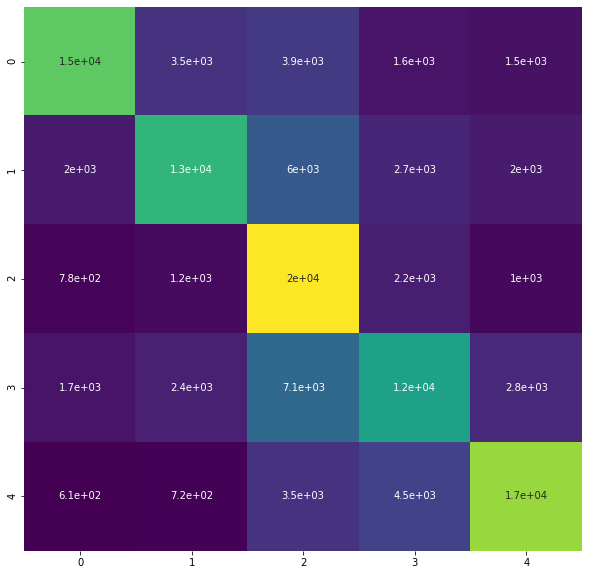

In [7]:
(fig, ax) = plt.subplots(1,1,figsize=(10,10))
calc_prediction(model_xgb_bow, X_test_bow, y_test_bow, categorical=False, ax=ax, title=None)

## Tf-IDF method
- train, test, val split
- tokenize the text
- Use TFIDF features from sklearn

In [8]:
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer

def prepare_TFIDF(df, col):
    df_train, df_test = train_test_split(df, test_size=0.2, random_state = 8848)
    
    vectorizer = TfidfVectorizer(use_idf=True, max_df=0.95)
    vectorizer.fit_transform(df_train[col].values)
    
    X_train = vectorizer.transform(df_train[col].values)
    X_test  = vectorizer.transform(df_test[col].values)
    
    y_train = df_train['sentiment'].values
    y_test  = df_test['sentiment'].values

    return X_train, X_test, y_train, y_test, vectorizer

X_train_tf, X_test_tf, y_train_tf, y_test_tf, vectorizer= prepare_TFIDF(df, "message_processed")

## Model : XGBoost for TFIDF method

In [9]:
model_xgb_tf = XGBClassifier(random_state=42, seed=2, colsample_bytree=0.6, subsample=0.7)
model_xgb_tf.fit(X_train_tf, y_train_tf)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.6, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=0, num_parallel_tree=1,
              objective='multi:softprob', random_state=42, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=None, seed=2, subsample=0.7,
              tree_method='exact', validate_parameters=1, verbosity=None)

## Prediction

Classification Report:
               precision    recall  f1-score   support

           0       0.76      0.65      0.70     25721
           1       0.64      0.53      0.58     26005
           2       0.53      0.79      0.64     25212
           3       0.55      0.46      0.50     25489
           4       0.69      0.69      0.69     26273

    accuracy                           0.62    128700
   macro avg       0.63      0.62      0.62    128700
weighted avg       0.63      0.62      0.62    128700




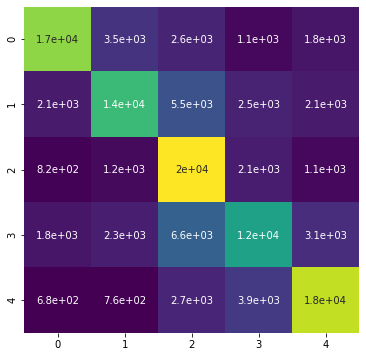

In [10]:
calc_prediction(model_xgb_tf, X_test_tf, y_test_tf, categorical=False, ax=None, title=None)

## Predictions for new texts

In [18]:
def Prediction_tf(doc, model=model_xgb_tf, vectorizer=vectorizer):    
    doc_processed = process_text(doc)
    X_in = vectorizer.transform([doc_processed])
    y_out = model.predict(X_in)[0]    
    print (f"TFIDF Prediction \t {y_out}")

In [20]:
def Prediction_bow(doc, model=model_xgb_bow, WORDS_TO_INDEX=WORDS_TO_INDEX):
    doc_processed = process_text(doc)
    X_in = sp_sparse.vstack([ sp_sparse.csr_matrix(bag_of_words(doc_processed,
                                                                WORDS_TO_INDEX)) ])
    y_out = model.predict(X_in)[0]
    print (f"BOW Prediction \t\t {y_out}")

In [21]:
twit1="$NIO $TSLA car spontaneously catches fire. \
    NIO car catches fire while being worked on in a \
    service factory. Which is more concerning? "

Prediction_bow(twit1)
Prediction_tf(twit1)

BOW Prediction 		 2
TFIDF Prediction 		 2
